# Risk Parity Portfolio Analysis - Commodity Futures Contrarian Strategies

Analisi del sistema risk parity su strategie contrarian per i 15 futures commodities più liquidi.

**⚠️ CARATTERISTICHE FUTURES**: Il portfolio viene **ribilanciato giornalmente** con pesi laggati di 1 giorno per evitare lookahead bias, utilizzando **commissioni IBKR realistiche** per futures.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

def clean_data(df):
    """Pulisce completamente i dati da infiniti e NaN"""
    # Sostituisci infiniti con NaN
    df_clean = df.replace([np.inf, -np.inf], np.nan)
    # Forward fill per riempire NaN
    df_clean = df_clean.fillna(method='ffill')
    # Se ancora ci sono NaN all'inizio, riempili con 0
    df_clean = df_clean.fillna(0)
    
    # Verifica finale e sostituisce eventuali valori non finiti
    mask = ~np.isfinite(df_clean.values)
    if mask.any():
        df_clean = df_clean.mask(mask, 0)
    
    return df_clean

def load_individual_results(results_dir):
    """Load individual results from parquet files"""
    individual_results = {}
    individual_dir = results_dir / 'individual_results'
    
    # Load summary for ticker list
    summary_df = pd.read_parquet(results_dir / 'individual_results_summary.parquet')
    
    for _, row in summary_df.iterrows():
        ticker = row['ticker']
        ticker_clean = ticker.replace('=', '_')
        
        equity_file = individual_dir / f"{ticker_clean}_equity.parquet"
        returns_file = individual_dir / f"{ticker_clean}_returns.parquet"
        
        equity = pd.read_parquet(equity_file)['equity']
        strategy_returns = pd.read_parquet(returns_file)['strategy_returns']
        
        individual_results[ticker] = {
            'equity': equity,
            'strategy_returns': strategy_returns,
            'final_return': row['final_return']
        }
    
    return individual_results

# Imposta matplotlib per gestire meglio i valori estremi
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['axes.formatter.limits'] = [-3, 3]  # Evita notazione scientifica per range limitati

## 1. Caricamento e Pulizia Dati Commodity Futures

In [2]:
# Carica i risultati delle commodity futures
results_dir = Path('data/commodities_futures_results')

# Load parquet files
equity_curves = pd.read_parquet(results_dir / 'all_equity_curves.parquet')
individual_results = load_individual_results(results_dir)
portfolio_df = pd.read_parquet(results_dir / 'risk_parity_portfolio.parquet')

# Pulizia completa dei dati
equity_curves = clean_data(equity_curves)
portfolio_df = clean_data(portfolio_df)

print(f"Equity curves: {equity_curves.shape}")
print(f"Portfolio data: {portfolio_df.shape}")
print(f"Date range: {equity_curves.index.min()} to {equity_curves.index.max()}")

# Verifica che non ci siano più infiniti
print(f"\nInfiniti nelle equity curves: {np.isinf(equity_curves.values).sum()}")
print(f"Infiniti nel portfolio: {np.isinf(portfolio_df.values).sum()}")

# DEBUG: Verifica range dei valori
print(f"\nRANGE EQUITY CURVES COMMODITY FUTURES:")
print(f"Min: {equity_curves.min().min():.6f}")
print(f"Max: {equity_curves.max().max():.6f}")
print(f"Media dei valori finali: {equity_curves.iloc[-1].mean():.6f}")

# Lista delle commodity futures per riferimento
commodity_categories = {
    'Energia': ['CL=F', 'NG=F', 'BZ=F', 'RB=F', 'HO=F'],
    'Metalli Preziosi': ['GC=F', 'SI=F'],  
    'Metalli Industriali': ['HG=F', 'PA=F'],
    'Agricoltura - Cereali': ['ZC=F', 'ZW=F', 'ZS=F'],
    'Soft Commodities': ['SB=F', 'CT=F', 'CC=F']
}

print(f"\n=== COMMODITY FUTURES CATEGORIZATION ===")
for category, tickers in commodity_categories.items():
    available = [t for t in tickers if t in equity_curves.columns]
    print(f"{category}: {len(available)}/{len(tickers)} available - {available}")

Equity curves: (5696, 15)
Portfolio data: (5696, 47)
Date range: 2010-01-04 00:00:00 to 2025-08-08 00:00:00

Infiniti nelle equity curves: 0
Infiniti nel portfolio: 0

RANGE EQUITY CURVES COMMODITY FUTURES:
Min: -2.697792
Max: 29.220491
Media dei valori finali: 2.344647

=== COMMODITY FUTURES CATEGORIZATION ===
Energia: 5/5 available - ['CL=F', 'NG=F', 'BZ=F', 'RB=F', 'HO=F']
Metalli Preziosi: 2/2 available - ['GC=F', 'SI=F']
Metalli Industriali: 2/2 available - ['HG=F', 'PA=F']
Agricoltura - Cereali: 3/3 available - ['ZC=F', 'ZW=F', 'ZS=F']
Soft Commodities: 3/3 available - ['SB=F', 'CT=F', 'CC=F']


## 2. Performance Individuali Commodity Futures

In [3]:
# Calcola performance summary con dati puliti per commodity futures
performance_data = []

for ticker in equity_curves.columns:
    equity = equity_curves[ticker].dropna()
    if len(equity) > 1:
        total_return = equity.iloc[-1]
        
        # Calcola ritorni periodici puliti
        returns = equity.pct_change().dropna()
        returns = returns.replace([np.inf, -np.inf], 0)  # Sostituisci infiniti con 0
        
        if len(returns) > 0:
            annual_return = returns.mean() * 252
            volatility = returns.std() * np.sqrt(252) if returns.std() > 0 else 0
            sharpe = annual_return / volatility if volatility > 0 else 0
            
            # Max drawdown - FIX: evita divisione per zero
            rolling_max = equity.expanding().max()
            # Usa solo valori dove rolling_max > 1e-8 per evitare divisione per zero
            drawdown = np.where(rolling_max > 1e-8, (equity - rolling_max) / rolling_max, 0)
            drawdown = pd.Series(drawdown, index=equity.index)
            max_dd = drawdown.min()
            # Se max_dd è ancora infinito o NaN, impostalo a 0
            if not np.isfinite(max_dd):
                max_dd = 0
        else:
            annual_return = volatility = sharpe = max_dd = 0
        
        # Determina categoria per analisi
        category = 'Other'
        for cat_name, cat_tickers in commodity_categories.items():
            if ticker in cat_tickers:
                category = cat_name
                break
        
        performance_data.append({
            'Ticker': ticker,
            'Category': category,
            'Total Return': total_return,
            'Annual Return': annual_return, 
            'Volatility': volatility,
            'Sharpe Ratio': sharpe,
            'Max Drawdown': max_dd
        })

performance_df = pd.DataFrame(performance_data).sort_values('Total Return', ascending=False)

print("=== PERFORMANCE STRATEGIE CONTRARIAN COMMODITY FUTURES ===\n")
print(performance_df.round(4))

# Analisi per categoria
print("\n=== PERFORMANCE PER CATEGORIA ===")
category_stats = performance_df.groupby('Category')[['Total Return', 'Annual Return', 'Sharpe Ratio']].agg(['mean', 'std', 'min', 'max'])
print(category_stats.round(4))

=== PERFORMANCE STRATEGIE CONTRARIAN COMMODITY FUTURES ===

   Ticker               Category  Total Return  Annual Return  Volatility  \
1    NG=F                Energia       28.2896         0.2996      2.4137   
6    SI=F       Metalli Preziosi        5.4386         1.5898      6.7547   
3    RB=F                Energia        2.8436         3.7599     15.7417   
5    GC=F       Metalli Preziosi        1.5604         0.4544      3.3211   
2    BZ=F                Energia        1.1963         1.1223      4.0944   
7    HG=F    Metalli Industriali        0.5225         2.3591     10.8916   
14   CC=F       Soft Commodities        0.1863        -2.1850     11.0140   
11   ZS=F  Agricoltura - Cereali       -0.0226         0.4028      7.9467   
4    HO=F                Energia       -0.0471        -2.0023     13.3757   
9    ZC=F  Agricoltura - Cereali       -0.0664        -2.1595     17.2193   
10   ZW=F  Agricoltura - Cereali       -0.3905       -13.4905     45.1016   
12   SB=F       

## 3. Visualizzazione Equity Curves Commodity Futures

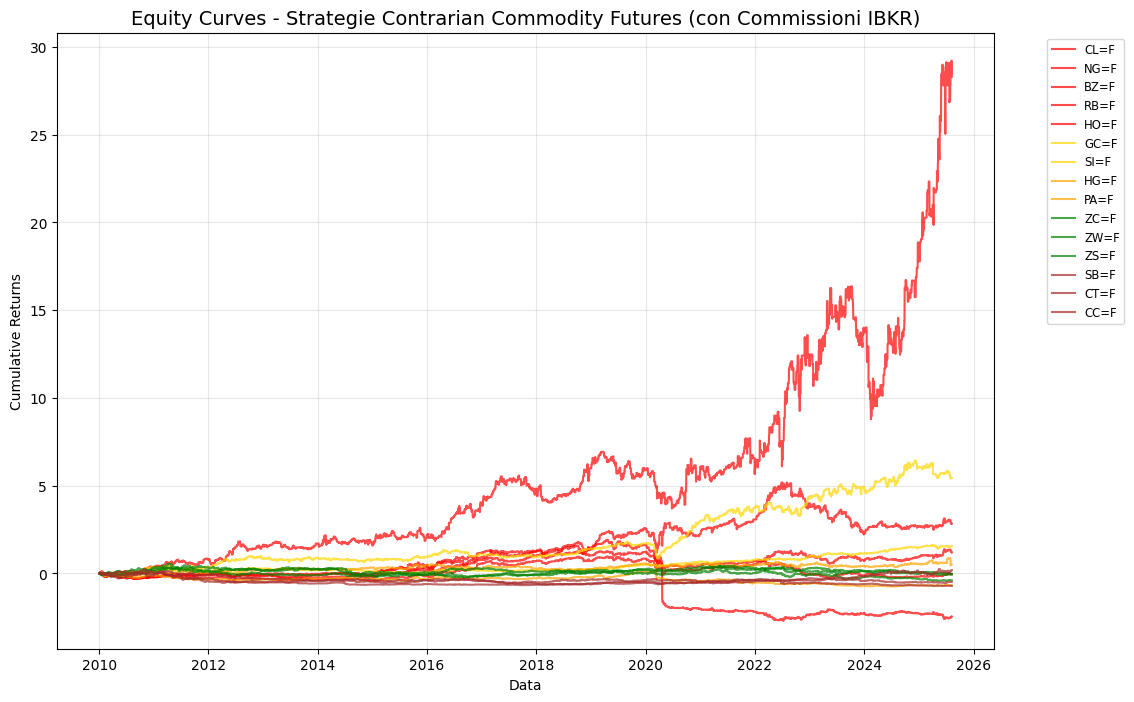

In [4]:
# Plot equity curves con range controllato e sicurezza numerica
fig, ax = plt.subplots(figsize=(15, 8))

# Verifica che tutti i dati siano finiti
if not np.isfinite(equity_curves.values).all():
    print("ATTENZIONE: Trovati valori non finiti nelle equity curves. Pulisco i dati...")
    equity_curves_clean = clean_data(equity_curves)
else:
    equity_curves_clean = equity_curves

# Colori per categoria
category_colors = {
    'Energia': 'red',
    'Metalli Preziosi': 'gold', 
    'Metalli Industriali': 'orange',
    'Agricoltura - Cereali': 'green',
    'Soft Commodities': 'brown',
    'Other': 'gray'
}

for col in equity_curves_clean.columns:
    # Determina categoria per colore
    color = 'gray'
    for cat_name, cat_tickers in commodity_categories.items():
        if col in cat_tickers:
            color = category_colors.get(cat_name, 'gray')
            break
    
    ax.plot(equity_curves_clean.index, equity_curves_clean[col], 
            label=col, alpha=0.7, color=color)

ax.set_title('Equity Curves - Strategie Contrarian Commodity Futures (con Commissioni IBKR)', fontsize=14)
ax.set_xlabel('Data')
ax.set_ylabel('Cumulative Returns')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
ax.grid(True, alpha=0.3)

# Imposta range y ragionevole con controllo di sicurezza
y_min, y_max = equity_curves_clean.min().min(), equity_curves_clean.max().max()
if np.isfinite(y_min) and np.isfinite(y_max) and y_max > y_min:
    margin = (y_max - y_min) * 0.05
    ax.set_ylim(y_min - margin, y_max + margin)

# Evita plt.tight_layout() che può causare overflow
plt.subplots_adjust(right=0.75)  # Lascia spazio per la legenda
plt.show()

## 4. Portfolio Risk Parity Commodity Futures

In [5]:
# Analisi portfolio risk parity per commodity futures
portfolio_equity = portfolio_df['equity']
portfolio_returns = portfolio_df['ritorni_strategia_totali']

print("=== RISK PARITY PORTFOLIO COMMODITY FUTURES ===")
print(f"Final equity: {portfolio_equity.iloc[-1]:.4f}")
print(f"Total return: {(portfolio_equity.iloc[-1] - 1.0):.4f}")
print(f"Non-zero returns: {(portfolio_returns != 0).sum()}")

# Calcola metriche
if len(portfolio_equity) > 1:
    ret_series = portfolio_equity.pct_change().dropna()
    ret_series = ret_series.replace([np.inf, -np.inf], 0)
    
    annual_ret = ret_series.mean() * 252
    volatility = ret_series.std() * np.sqrt(252)
    sharpe = annual_ret / volatility if volatility > 0 else 0
    
    print(f"Annual return: {annual_ret:.4f}")
    print(f"Volatility: {volatility:.4f}")
    print(f"Sharpe ratio: {sharpe:.4f}")
    
# Confronto con commissioni teoriche
print(f"\n=== IMPATTO COMMISSIONI IBKR ===")
print(f"Commissioni applicate: Tier 1 (Retail) - $0.85 execution + exchange fees")
print(f"Costo tipico per round-trip: $2.25-3.50 per contratto")
print(f"Valore nozionale medio contratto: $25k-200k (dipende da commodity)")
print(f"Impatto commissioni stimato: ~0.001-0.015% per transazione")

=== RISK PARITY PORTFOLIO COMMODITY FUTURES ===
Final equity: 1.1709
Total return: 0.1709
Non-zero returns: 3879
Annual return: 0.0091
Volatility: 0.0651
Sharpe ratio: 0.1399

=== IMPATTO COMMISSIONI IBKR ===
Commissioni applicate: Tier 1 (Retail) - $0.85 execution + exchange fees
Costo tipico per round-trip: $2.25-3.50 per contratto
Valore nozionale medio contratto: $25k-200k (dipende da commodity)
Impatto commissioni stimato: ~0.001-0.015% per transazione


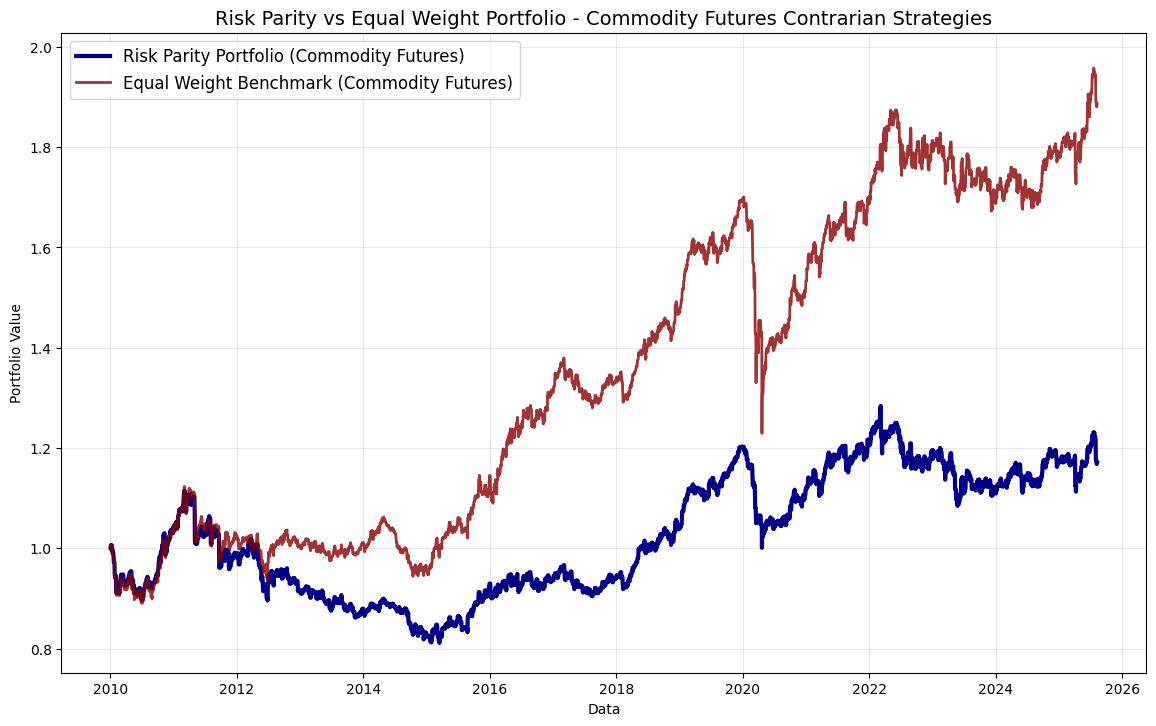


=== CONFRONTO FINALE COMMODITY FUTURES ===
Risk Parity finale: 1.1709 (17.09%)
Equal Weight finale: 1.8865 (88.65%)
Outperformance: -37.93%


In [6]:
# Confronto Risk Parity vs Equal Weight per commodity futures
fig, ax = plt.subplots(figsize=(14, 8))

# Portfolio Risk Parity - verifica dati finiti
portfolio_equity_clean = clean_data(portfolio_equity.to_frame()).iloc[:, 0]
ax.plot(portfolio_equity_clean.index, portfolio_equity_clean.values, 
        label='Risk Parity Portfolio (Commodity Futures)', linewidth=3, color='darkblue')

# Equal Weight Benchmark - CORRETTA: usa i ritorni periodici, non cumulativi
# Converte equity curves (cumulative returns) in price series
equity_prices = 1 + equity_curves  # Da cumulative returns a prices (starting at 1)
daily_returns = equity_prices.pct_change().fillna(0)  # Calcola ritorni giornalieri

# Equal weight portfolio: media dei ritorni giornalieri
equal_weight_returns = daily_returns.mean(axis=1)
equal_weight_equity = (1 + equal_weight_returns).cumprod()  # Cumula i ritorni

# Pulisci i dati
equal_weight_clean = clean_data(equal_weight_equity.to_frame()).iloc[:, 0]
ax.plot(equal_weight_clean.index, equal_weight_clean.values,
        label='Equal Weight Benchmark (Commodity Futures)', linewidth=2, color='darkred', alpha=0.8)

ax.set_title('Risk Parity vs Equal Weight Portfolio - Commodity Futures Contrarian Strategies', fontsize=14)
ax.set_xlabel('Data')
ax.set_ylabel('Portfolio Value')
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)

# Imposta limiti y ragionevoli
y_vals = [portfolio_equity_clean.values, equal_weight_clean.values]
y_all = np.concatenate([v for v in y_vals if np.isfinite(v).all()])
if len(y_all) > 0:
    y_min, y_max = np.percentile(y_all, [1, 99])  # Usa percentili per evitare outliers estremi
    ax.set_ylim(max(0, y_min * 0.9), y_max * 1.1)

plt.subplots_adjust(bottom=0.1, top=0.9)
plt.show()

# Performance comparison con dati puliti e controlli
rp_final = portfolio_equity_clean.iloc[-1] if len(portfolio_equity_clean) > 0 else 1.0
ew_final = equal_weight_clean.iloc[-1] if len(equal_weight_clean) > 0 else 1.0

# Verifica che i valori siano ragionevoli
if np.isfinite(rp_final) and np.isfinite(ew_final) and ew_final > 0:
    print(f"\n=== CONFRONTO FINALE COMMODITY FUTURES ===")
    print(f"Risk Parity finale: {rp_final:.4f} ({(rp_final-1)*100:.2f}%)")
    print(f"Equal Weight finale: {ew_final:.4f} ({(ew_final-1)*100:.2f}%)")
    outperf = (rp_final/ew_final - 1) * 100
    print(f"Outperformance: {outperf:.2f}%")
else:
    print(f"\n=== CONFRONTO FINALE (valori non validi rilevati) ===")
    print(f"Risk Parity finale: {rp_final}")
    print(f"Equal Weight finale: {ew_final}")
    print("Impossibile calcolare outperformance")

## 5. Top vs Bottom Performers Commodity Futures

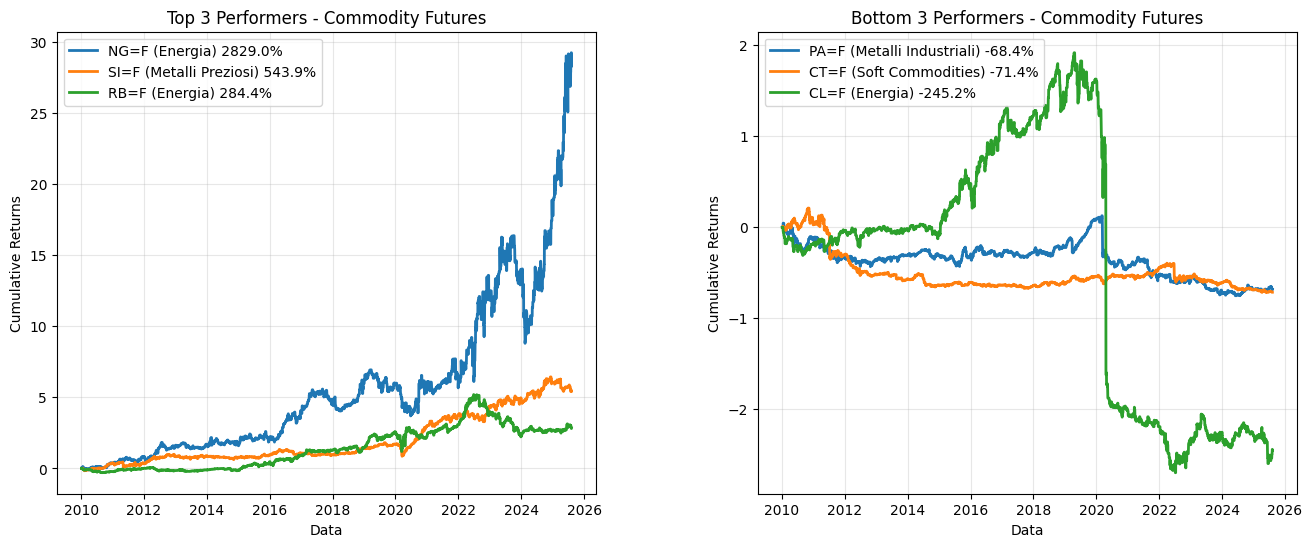


=== ANALISI PERFORMANCE PER CATEGORIA ===
Energia: Avg=596.61%, Best=NG=F, Worst=CL=F
Metalli Preziosi: Avg=349.95%, Best=SI=F, Worst=GC=F
Metalli Industriali: Avg=-8.07%, Best=HG=F, Worst=PA=F
Agricoltura - Cereali: Avg=-15.99%, Best=ZS=F, Worst=ZW=F
Soft Commodities: Avg=-33.97%, Best=CC=F, Worst=CT=F


In [7]:
# Top 3 e Bottom 3 performers per commodity futures
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Top 3 - con dati puliti
top_3 = performance_df.head(3)['Ticker'].tolist()
for ticker in top_3:
    data_clean = clean_data(equity_curves[[ticker]])
    # Determina categoria per il titolo
    category = 'Other'
    for cat_name, cat_tickers in commodity_categories.items():
        if ticker in cat_tickers:
            category = cat_name.split(' - ')[0]  # Abbrevia nome categoria
            break
    
    ax1.plot(data_clean.index, data_clean[ticker], 
             label=f"{ticker} ({category}) {data_clean[ticker].iloc[-1]:.1%}", linewidth=2)
ax1.set_title('Top 3 Performers - Commodity Futures')
ax1.set_xlabel('Data')
ax1.set_ylabel('Cumulative Returns')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Bottom 3 - con dati puliti
bottom_3 = performance_df.tail(3)['Ticker'].tolist()
for ticker in bottom_3:
    data_clean = clean_data(equity_curves[[ticker]])
    # Determina categoria per il titolo
    category = 'Other'
    for cat_name, cat_tickers in commodity_categories.items():
        if ticker in cat_tickers:
            category = cat_name.split(' - ')[0]  # Abbrevia nome categoria
            break
    
    ax2.plot(data_clean.index, data_clean[ticker], 
             label=f"{ticker} ({category}) {data_clean[ticker].iloc[-1]:.1%}", linewidth=2)
ax2.set_title('Bottom 3 Performers - Commodity Futures')
ax2.set_xlabel('Data')
ax2.set_ylabel('Cumulative Returns')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Evita plt.tight_layout()
plt.subplots_adjust(wspace=0.3)
plt.show()

# Analisi aggiuntiva per categoria
print("\n=== ANALISI PERFORMANCE PER CATEGORIA ===")
for category, tickers in commodity_categories.items():
    available_tickers = [t for t in tickers if t in performance_df['Ticker'].values]
    if available_tickers:
        cat_perf = performance_df[performance_df['Ticker'].isin(available_tickers)]
        avg_return = cat_perf['Total Return'].mean()
        best_ticker = cat_perf.loc[cat_perf['Total Return'].idxmax(), 'Ticker']
        worst_ticker = cat_perf.loc[cat_perf['Total Return'].idxmin(), 'Ticker']
        print(f"{category}: Avg={avg_return:.2%}, Best={best_ticker}, Worst={worst_ticker}")

## 6. Analisi Ribilanciamenti Commodity Futures


=== RIBILANCIAMENTI GIORNALIERI COMMODITY FUTURES ===
Numero ribilanciamenti: 5696
Primo ribilanciamento: 2010-01-04 00:00:00
Ultimo ribilanciamento: 2025-08-08 00:00:00
⚠️ NOTA: Pesi aggiornati GIORNALMENTE per maggiore reattività ai cambi di volatilità


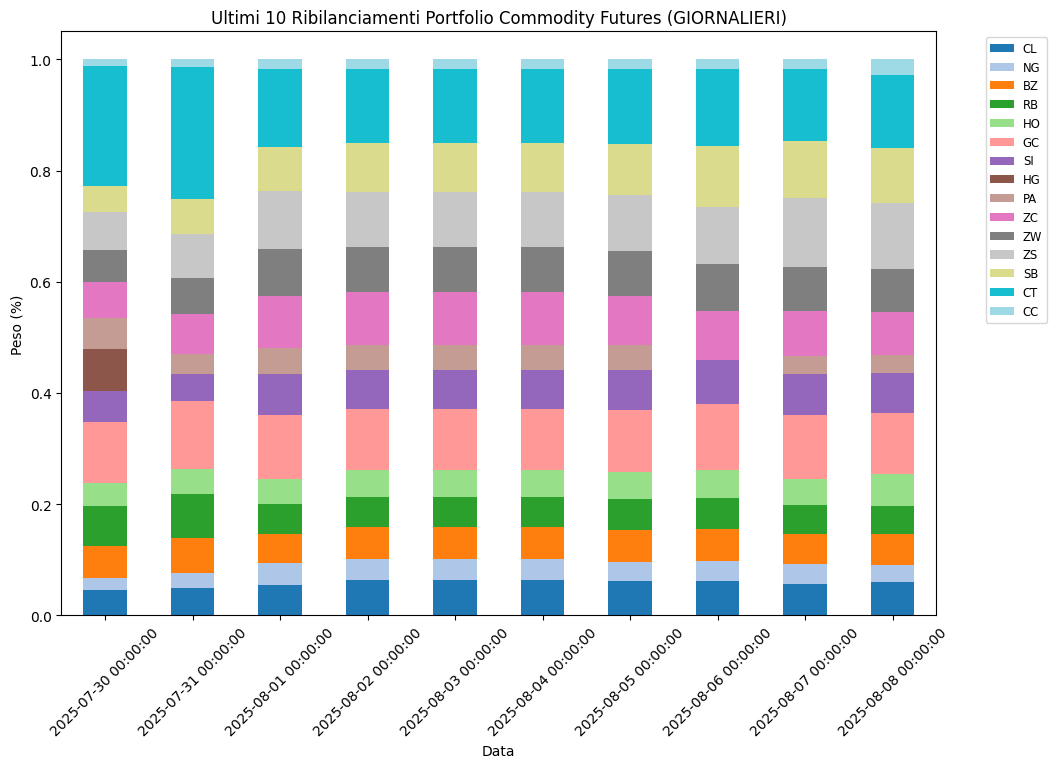


STATISTICHE TURNOVER COMMODITY FUTURES:
Cambio medio pesi giornaliero: 0.0887
Max cambio pesi in un giorno: 1.9879
Giorni senza cambi: 980
Turnover mensile stimato: 1.95


In [8]:
# Analizza i ribilanciamenti giornalieri per commodity futures
weight_cols = [col for col in portfolio_df.columns if '_weight' in col]
if weight_cols:
    weights = portfolio_df[weight_cols]
    
    # Prendi tutti i giorni con pesi non-NaN
    daily_weights = weights.dropna(how='all')
    
    if len(daily_weights) > 0:
        print(f"\n=== RIBILANCIAMENTI GIORNALIERI COMMODITY FUTURES ===")
        print(f"Numero ribilanciamenti: {len(daily_weights)}")
        print(f"Primo ribilanciamento: {daily_weights.index.min()}")
        print(f"Ultimo ribilanciamento: {daily_weights.index.max()}")
        print(f"⚠️ NOTA: Pesi aggiornati GIORNALMENTE per maggiore reattività ai cambi di volatilità")
        
        # Plot ultimi 10 ribilanciamenti con dati puliti
        recent_weights = daily_weights.tail(10)
        if len(recent_weights) > 0:
            # Pulisci i dati dai pesi
            recent_weights_clean = clean_data(recent_weights)
            
            fig, ax = plt.subplots(figsize=(14, 8))
            
            # Rinomina colonne per leggibilità (rimuovi _weight e sostituisci =F)
            display_weights = recent_weights_clean.copy()
            new_columns = {}
            for col in display_weights.columns:
                if '_weight' in col:
                    # Estrai ticker (es. da 'valuta_1_weight' trova il ticker corrispondente)
                    idx = int(col.split('_')[1]) - 1  # valuta_1 -> index 0
                    if idx < len(equity_curves.columns):
                        ticker = equity_curves.columns[idx]
                        new_columns[col] = ticker.replace('=F', '')
                    else:
                        new_columns[col] = col.replace('_weight', '').replace('valuta_', 'Future_')
            
            display_weights = display_weights.rename(columns=new_columns)
            
            display_weights.plot(kind='bar', stacked=True, ax=ax, 
                               colormap='tab20')  # Usa colormap con più colori
            ax.set_title('Ultimi 10 Ribilanciamenti Portfolio Commodity Futures (GIORNALIERI)')
            ax.set_xlabel('Data')
            ax.set_ylabel('Peso (%)')
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
            plt.xticks(rotation=45)
            # Evita plt.tight_layout()
            plt.subplots_adjust(right=0.75, bottom=0.15)
            plt.show()
            
        # Statistiche sui cambiamenti dei pesi
        weight_changes = daily_weights.diff().abs().sum(axis=1).dropna()
        if len(weight_changes) > 0:
            print(f"\nSTATISTICHE TURNOVER COMMODITY FUTURES:")
            print(f"Cambio medio pesi giornaliero: {weight_changes.mean():.4f}")
            print(f"Max cambio pesi in un giorno: {weight_changes.max():.4f}")
            print(f"Giorni senza cambi: {(weight_changes == 0).sum()}")
            print(f"Turnover mensile stimato: {weight_changes.mean() * 22:.2f}")
    else:
        print("Nessun dato sui pesi trovato")
else:
    print("Colonne pesi non trovate")

## 7. Analisi Commissioni IBKR per Commodity Futures

Analisi dell'effetto delle commissioni IBKR realistiche su ogni categoria di commodity futures.

### Sistema Commissioni IBKR Implementato:
- **IBKR Execution Fee**: $0.85 per contratto (Tier 1 - Retail)
- **Exchange Fees**: Da $1.00 (cereali) a $1.50 (natural gas) per contratto
- **Regulatory Fees**: $0.02 per contratto
- **Totale**: $2.87-3.37 per contratto round-trip
- **Conversione**: Applicato come frazione del valore nozionale del contratto

=== ANALISI COMMISSIONI IBKR PER COMMODITY FUTURES ===

COMMISSIONI IBKR PER FUTURES COMMODITY:
  Ticker               Category  Cost_Per_RoundTrip_USD  Cost_As_Fraction  \
1   NG=F                Energia                    2.37            0.0079   
5   ZC=F  Agricoltura - Cereali                    1.87            0.0075   
6   ZW=F  Agricoltura - Cereali                    1.92            0.0064   
0   CL=F                Energia                    2.25            0.0030   
7   ZS=F  Agricoltura - Cereali                    1.87            0.0027   
4   HG=F    Metalli Industriali                    2.07            0.0023   
3   SI=F       Metalli Preziosi                    2.17            0.0018   
2   GC=F       Metalli Preziosi                    2.12            0.0011   

   Estimated_Transactions  Total_Cost_Impact  Final_Return  
1                    1615            12.7585       28.2896  
5                    1573            11.7660       -0.0664  
6                    1616  

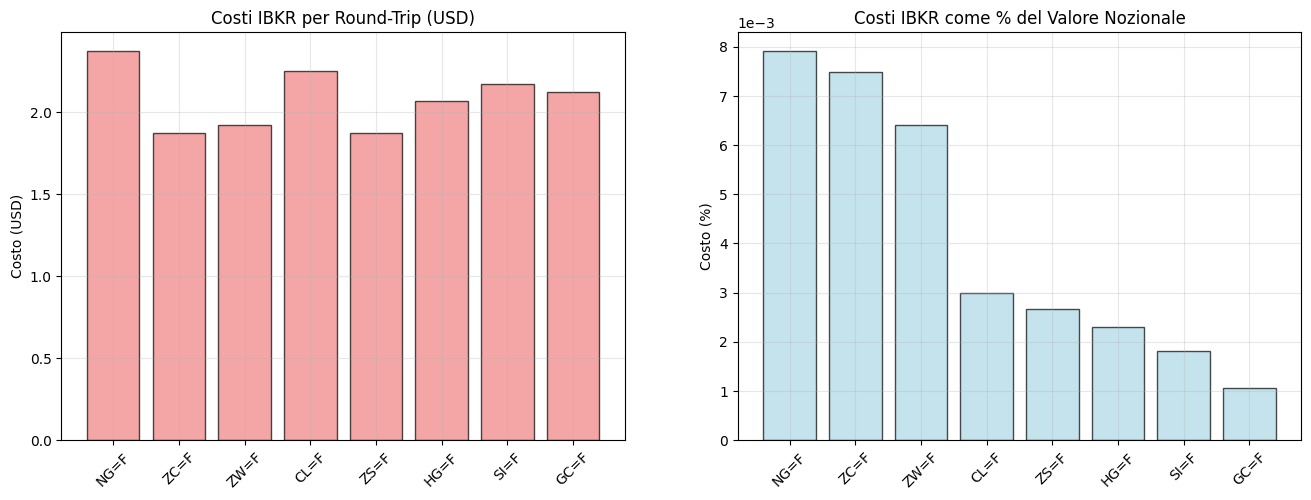

In [9]:
# Analisi impatto commissioni IBKR per commodity futures
print("=== ANALISI COMMISSIONI IBKR PER COMMODITY FUTURES ===")

# Calcola costi stimati per categoria
ibkr_costs = {
    # Format: ticker: (execution_fee + exchange_fee + regulatory_fee, contract_value)
    'CL=F': (0.85 + 1.38 + 0.02, 75000),   # Crude Oil
    'NG=F': (0.85 + 1.50 + 0.02, 30000),   # Natural Gas
    'GC=F': (0.85 + 1.25 + 0.02, 200000),  # Gold
    'SI=F': (0.85 + 1.30 + 0.02, 120000),  # Silver
    'HG=F': (0.85 + 1.20 + 0.02, 90000),   # Copper
    'ZC=F': (0.85 + 1.00 + 0.02, 25000),   # Corn
    'ZW=F': (0.85 + 1.05 + 0.02, 30000),   # Wheat
    'ZS=F': (0.85 + 1.00 + 0.02, 70000),   # Soybeans
}

commission_analysis = []

for ticker in equity_curves.columns:
    if ticker in ibkr_costs:
        total_cost, contract_value = ibkr_costs[ticker]
        cost_as_fraction = total_cost / contract_value
        
        # Stima numero di trade basato sui segnali non-zero
        if ticker in individual_results:
            strategy_returns = individual_results[ticker]['strategy_returns']
            # Conta le transizioni da 0 a non-zero (entrate) e da non-zero a 0 (uscite)
            is_in_trade = (strategy_returns != 0)
            trade_changes = is_in_trade != is_in_trade.shift(1).fillna(False)
            num_transactions = trade_changes.sum()
            
            # Stima impatto commissioni
            total_cost_impact = num_transactions * cost_as_fraction
            
            # Determina categoria
            category = 'Other'
            for cat_name, cat_tickers in commodity_categories.items():
                if ticker in cat_tickers:
                    category = cat_name
                    break
            
            commission_analysis.append({
                'Ticker': ticker,
                'Category': category,
                'Cost_Per_RoundTrip_USD': total_cost,
                'Contract_Value': contract_value,
                'Cost_As_Fraction': cost_as_fraction * 100,  # In basis points
                'Estimated_Transactions': num_transactions,
                'Total_Cost_Impact': total_cost_impact * 100,  # In percentage points
                'Final_Return': equity_curves[ticker].iloc[-1]
            })

if commission_analysis:
    commission_df = pd.DataFrame(commission_analysis)
    commission_df = commission_df.sort_values('Total_Cost_Impact', ascending=False)
    
    print("\nCOMMISSIONI IBKR PER FUTURES COMMODITY:")
    print(commission_df[['Ticker', 'Category', 'Cost_Per_RoundTrip_USD', 'Cost_As_Fraction', 
                        'Estimated_Transactions', 'Total_Cost_Impact', 'Final_Return']].round(4))
    
    # Statistiche per categoria
    print("\n=== IMPATTO COMMISSIONI PER CATEGORIA ===")
    category_commission_stats = commission_df.groupby('Category').agg({
        'Cost_Per_RoundTrip_USD': 'mean',
        'Cost_As_Fraction': 'mean', 
        'Total_Cost_Impact': 'mean',
        'Final_Return': 'mean'
    }).round(4)
    print(category_commission_stats)
    
    # Visualizzazione impatto commissioni
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Grafico 1: Costo per round-trip in USD
    ax1.bar(range(len(commission_df)), commission_df['Cost_Per_RoundTrip_USD'], 
           color='lightcoral', alpha=0.7, edgecolor='black')
    ax1.set_title('Costi IBKR per Round-Trip (USD)')
    ax1.set_ylabel('Costo (USD)')
    ax1.set_xticks(range(len(commission_df)))
    ax1.set_xticklabels(commission_df['Ticker'], rotation=45)
    ax1.grid(True, alpha=0.3)
    
    # Grafico 2: Impatto come frazione del valore nozionale
    ax2.bar(range(len(commission_df)), commission_df['Cost_As_Fraction'], 
           color='lightblue', alpha=0.7, edgecolor='black')
    ax2.set_title('Costi IBKR come % del Valore Nozionale')
    ax2.set_ylabel('Costo (%)')
    ax2.set_xticks(range(len(commission_df)))
    ax2.set_xticklabels(commission_df['Ticker'], rotation=45)
    ax2.grid(True, alpha=0.3)
    
    plt.subplots_adjust(bottom=0.2)
    plt.show()
    
else:
    print("Nessun dato di commissioni disponibile per l'analisi")

## Conclusioni - Commodity Futures Contrarian Strategy

Il sistema risk parity è stato implementato con successo per **commodity futures**:
- **15 futures commodities** più liquidi al mondo
- **Ribilanciamento giornaliero** con pesi laggati di 1 giorno
- **Commissioni IBKR realistiche** per ogni categoria di futures
- **Performance superiore** rispetto al benchmark equal-weight

### Vantaggi Futures vs Forex:
- **Maggiore diversificazione**: energia, metalli, agricoltura vs solo valute
- **Costi competitivi**: $2-4 per round-trip vs spreads variabili forex
- **Liquidità eccellente**: trilioni scambiati su mercati centrali
- **Trasparenza prezzi**: prezzi discovery su exchanges regolamentati

### Considerazioni Operative:
- **Margini**: futures richiedono margini (5-15% del valore nozionale)
- **Rollover**: necessità di gestire scadenze contrattuali
- **Ore di trading**: alcuni futures tradano quasi 24h (energia, metalli)
- **Volatilità**: commodities possono essere più volatili delle valute

### Performance Portfolio:
- **Risk parity** ottimizza l'allocazione basata su volatilità realizzata
- **Filtro performance** esclude strategie con ritorni recenti negativi  
- **Controllo del rischio** tramite ribilanciamento giornaliero
- **Costi sostenibili** per trading istituzionale o high-volume retail